In [1]:
import math

from openfermionpyscf import run_pyscf
from openfermion.transforms import binary_code_transform, bravyi_kitaev_code, get_fermion_operator
from openfermion.hamiltonians import MolecularData
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.utils import count_qubits
from pyscf import gto, scf, mcscf

from helper_functions import *
from XBK_method import *

In [3]:
#create molecule
name = 'H3'
charge = 1
multiplicity = 1
basis = 'sto-6g'

bond_length = 1.1
geometry = get_molGeometry(name, bond_length)

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

In [4]:
#run RHF calculations
molecule = run_pyscf(molecule, run_scf=True)
hf_energy = float(molecule.hf_energy)
hf_data = molecule._pyscf_data['scf']

print(hf_energy)

-1.2400693045269722


In [5]:
#define active space
n_active_electrons = 2
n_active_orbitals = 3
occupied_indices, active_indices = get_active_space(molecule, n_active_electrons, n_active_orbitals)

#run CASCI calculations
casci_data = hf_data.CASCI(n_active_orbitals, n_active_electrons).run(verbose=False)
casci_energy = float(casci_data.e_tot)

print(casci_energy)

-1.2722647705358234


In [6]:
#convert to fermionic Hamiltonian
molecular_H = molecule.get_molecular_hamiltonian(occupied_indices=occupied_indices, active_indices=active_indices)
if molecular_H[()] == None:
    molecular_H[()] = 0
fermionic_H = get_fermion_operator(molecular_H)

#add penalty term to ensure correct number of electrons in ground state
weight = 5
penalty_term = FermionOperator('', n_active_electrons)

for i in range(molecular_H.n_qubits):
    penalty_term += FermionOperator(str(i)+'^ '+str(i), -1)
fermionic_H += weight*penalty_term**2

print(fermionic_H)

21.443210575236364 [] +
-21.623075395384372 [0^ 0] +
5.0 [0^ 0 0^ 0] +
5.0 [0^ 0 1^ 1] +
5.0 [0^ 0 2^ 2] +
5.0 [0^ 0 3^ 3] +
5.0 [0^ 0 4^ 4] +
5.0 [0^ 0 5^ 5] +
0.28143545550270405 [0^ 0^ 0 0] +
0.07258994740907983 [0^ 0^ 2 2] +
0.07258994740907991 [0^ 0^ 4 4] +
0.28143545550270405 [0^ 1^ 1 0] +
0.07258994740907983 [0^ 1^ 3 2] +
0.07258994740907991 [0^ 1^ 5 4] +
0.07258994740907983 [0^ 2^ 0 2] +
0.27480121211888675 [0^ 2^ 2 0] +
0.04209678641731164 [0^ 2^ 2 2] +
-0.026713793031650772 [0^ 2^ 2 4] +
-0.026713793031650765 [0^ 2^ 4 2] +
-0.042096786417311544 [0^ 2^ 4 4] +
0.07258994740907983 [0^ 3^ 1 2] +
0.27480121211888675 [0^ 3^ 3 0] +
0.04209678641731164 [0^ 3^ 3 2] +
-0.026713793031650772 [0^ 3^ 3 4] +
-0.026713793031650765 [0^ 3^ 5 2] +
-0.042096786417311544 [0^ 3^ 5 4] +
0.07258994740907991 [0^ 4^ 0 4] +
-0.026713793031650765 [0^ 4^ 2 2] +
-0.042096786417311544 [0^ 4^ 2 4] +
0.27480121211888686 [0^ 4^ 4 0] +
-0.04209678641731152 [0^ 4^ 4 2] +
0.026713793031650654 [0^ 4^ 4 4] +
0.072

In [8]:
#convert to Pauli operator Hamiltonian
binary_code = bravyi_kitaev_code(molecular_H.n_qubits)
qubit_H = binary_code_transform(fermionic_H, binary_code)
qubit_H.compress()

#apply symmetry reductions and calculate minimum eigenvalue (should be equal to CASCI energy)
sectors = taper_qubits(qubit_H)
qubit_H, min_eigenvalue = sector_with_ground(sectors)
m = count_qubits(qubit_H)

print(min_eigenvalue, '\n')
print(qubit_H)

-1.27226477053585 

12.052315964211402 [] +
-0.02104839320865584 [X0] +
0.021048393208655806 [X0 X1 X2] +
-0.0133568965158254 [X0 X1 Z2 X3] +
0.021048393208655845 [X0 X1 Z2 Z3] +
-0.0133568965158254 [X0 X1 X3] +
0.021048393208655845 [X0 X1 Z3] +
0.021048393208655806 [X0 Y1 Y2] +
0.013356896515825379 [X0 Z1 X2 X3] +
-0.021048393208655806 [X0 Z1 X2 Z3] +
0.021048393208655796 [X0 Z1 Z2] +
-0.013356896515825379 [X0 Z1 X3] +
0.021048393208655796 [X0 Z1 Z3] +
0.013356896515825379 [X0 X2 X3] +
-0.021048393208655806 [X0 X2 Z3] +
0.013356896515825414 [X0 Z2 X3] +
-0.02104839320865584 [X0 Z2 Z3] +
-0.013356896515825403 [Y0 X1 X2 Y3] +
-0.013356896515825403 [Y0 X1 Y2 X3] +
0.021048393208655806 [Y0 X1 Y2 Z3] +
0.013356896515825403 [Y0 Y1 X2 X3] +
-0.021048393208655806 [Y0 Y1 X2 Z3] +
-0.013356896515825403 [Y0 Y1 Y2 Y3] +
-0.0133568965158254 [Y0 Y1 Z2 X3] +
0.021048393208655796 [Y0 Y1 Z2 Z3] +
-0.0133568965158254 [Y0 Y1 X3] +
0.021048393208655796 [Y0 Y1 Z3] +
0.013356896515825414 [Y0 Z1 Y2 X3] +
-0

In [9]:
from openfermion import get_sparse_operator

result = XBK_transform(qubit_H, r=1, p=1)

In [ ]:
poly = {(0,): -1, (1,): 1, (2,): 1.5, (0, 1): -1, (0, 1, 2): -2}
strength = 2
# bqm = dimod.make_quadratic(poly, 5.0, dimod.SPIN)
bqm = dimod.higherorder.utils.make_quadratic(convert_dict(result.terms), strength, dimod.SPIN)
# bqm = dimod.higherorder.utils.make_quadratic(poly, strength, dimod.SPIN)

BinaryQuadraticModel({'s1': -8.688969953434883, 's0': 1.640717727751352, 's1*s0': -1.0, 'auxs1,s0': -2.0, 's3': 1.6594384070931008, 's2': -8.688969953434883, 's3*s2': -1.0, 'auxs3,s2': -2.0}, {('s0', 's1'): -1.6374006060594435, ('s1*s0', 's1'): 1.0, ('s1*s0', 's0'): 1.0, ('auxs1,s0', 's1'): 2.0, ('auxs1,s0', 's0'): 2.0, ('auxs1,s0', 's1*s0'): 2.0, ('s3', 's1'): -2.6374006060594435, ('s3', 's0'): 2.659438407093101, ('s3', 's1*s0'): -7.688969953434883, ('s2', 's1'): 7.406640049526931, ('s2', 's0'): -2.6374006060594435, ('s2', 's1*s0'): 7.406640049526931, ('s2', 's3'): -6.688969953434883, ('s3*s2', 's1'): 2.6201111641237462, ('s3*s2', 's0'): -2.6374006060594435, ('s3*s2', 's1*s0'): 2.6201111641237462, ('s3*s2', 's3'): 1.0, ('s3*s2', 's2'): 1.0, ('auxs3,s2', 's3'): 2.0, ('auxs3,s2', 's2'): 2.0, ('auxs3,s2', 's3*s2'): 2.0}, 20.052315964211402, 'SPIN')


In [133]:
bqm.quadratic

{('s14', 's12'): -1.9625388101038062, ('s12*s14', 's12'): 1.0, ('s12*s14', 's14'): 1.0, ('auxs12,s14', 's12'): 2.0, ('auxs12,s14', 's14'): 2.0, ('auxs12,s14', 's12*s14'): 2.0, ('s9', 's12'): -0.32513820404436294, ('s9', 's14'): 0.9310921044930303, ('s9', 's12*s14'): 0.9224907820619102, ('s11', 's12'): 0.3394246252852898, ('s11', 's14'): -0.9611212441793604, ('s11', 's12*s14'): -0.32513820404436294, ('s11', 's9'): -1.9625388101038066, ('s9*s11', 's12'): -0.9611212441793604, ('s9*s11', 's14'): 0.32997184820105296, ('s9*s11', 's12*s14'): 0.33189472237426054, ('s9*s11', 's9'): 1.0, ('s9*s11', 's11'): 1.0, ('auxs9,s11', 's9'): 2.0, ('auxs9,s11', 's11'): 2.0, ('auxs9,s11', 's9*s11'): 2.0, ('s6', 's12'): -0.32513820404436294, ('s6', 's14'): 1.4979381730953052, ('s6', 's12*s14'): 0.330089715968919, ('s6', 's9'): 0.9310921044930303, ('s6', 's11'): -0.9611212441793604, ('s6', 's9*s11'): 0.32997184820105296, ('s4', 's12'): 1.5065394955264253, ('s4', 's14'): -0.32513820404436294, ('s4', 's12*s14')

In [229]:
deck = set()
for key in bqm.quadratic.keys():
    deck.add(key[0])
    deck.add(key[1])

int_list = []
str_list = []
for elem in deck:
    if isinstance(elem, str):
        str_list.append(elem)
    elif (isinstance(elem, int)):
        int_list.append(elem)
#post processing
max_int = -1
if len(int_list) != 0:
    max_int = max(int_list)

mapping = {}

for elem in str_list:
    mapping[elem] = max_int+1
    max_int+=1

for elem in str_list:
    int_list.append(mapping[elem])

print(int_list)

[0, 1, 2, 3, 4, 5, 6, 7]


In [145]:
ans[('s14', 's12')]

-1.9625388101038062

In [151]:
mapping['s14']

85

In [152]:
mapping['s12']

42

In [230]:
Q = np.zeros((len(int_list), len(int_list)))
ans = bqm.quadratic
for a,b in ans.keys():
    ans_one = ans[(a,b)]
    if isinstance(a, str):
        a = mapping[a]
    if isinstance(b, str):
        b = mapping[b]
    Q[a][b] = ans_one
    Q[b][a] = ans_one

In [231]:
Q.shape

(8, 8)

In [171]:
import torch
from qadence import QuantumModel

In [71]:
qubo, constant = bqm.to_qubo()

In [187]:
Q = np.array(
    [
        [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
        [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
        [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
        [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
        [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
    ]
)

In [232]:
import numpy as np
import numpy.typing as npt
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from qadence import RydbergDevice

def qubo_register_coords(Q: np.ndarray, device: RydbergDevice) -> list:
    """Compute coordinates for register."""

    def evaluate_mapping(new_coords, *args):
        """Cost function to minimize. Ideally, the pairwise
        distances are conserved"""
        Q, shape = args
        new_coords = np.reshape(new_coords, shape)
        interaction_coeff = device.coeff_ising
        new_Q = squareform(interaction_coeff / pdist(new_coords) ** 6)
        return np.linalg.norm(new_Q - Q)

    shape = (len(Q), 2)
    np.random.seed(0)
    x0 = np.random.random(shape).flatten()
    res = minimize(
        evaluate_mapping,
        x0,
        args=(Q, shape),
        method="Nelder-Mead",
        tol=1e-6,
        options={"maxiter": 200000, "maxfev": None},
    )
    return [(x, y) for (x, y) in np.reshape(res.x, (len(Q), 2))]

In [213]:
len(Q)

104

In [233]:
# Loss function to guide the optimization routine
def loss(model: QuantumModel, *args) -> tuple[torch.Tensor, dict]:
    to_arr_fn = lambda bitstring: np.array(list(bitstring), dtype=int)
    cost_fn = lambda arr: arr.T @ Q @ arr
    samples = model.sample({}, n_shots=1000)[0]
    cost_fn = sum(samples[key] * cost_fn(to_arr_fn(key)) for key in samples)
    return torch.tensor(cost_fn / sum(samples.values())), {}

In [234]:
from qadence import QuantumCircuit, Register, RydbergDevice
from qadence import chain, AnalogRX, AnalogRZ

# Device specification and atomic register
device = RydbergDevice(rydberg_level=70)

reg = Register.from_coordinates(
    qubo_register_coords(Q, device), device_specs=device
)

# Analog variational quantum circuit
layers = 2
block = chain(*[AnalogRX(f"t{i}") * AnalogRZ(f"s{i}") for i in range(layers)])
circuit = QuantumCircuit(reg, block)

In [237]:
model = QuantumModel(circuit)
initial_counts = model.sample({}, n_shots=1000)[0]

In [241]:
initial_counts

OrderedCounter({'00000000': 692,
                '00010000': 38,
                '00001000': 37,
                '00000001': 33,
                '00000100': 32,
                '00100000': 32,
                '01000000': 29,
                '10000000': 29,
                '00000010': 26,
                '00011000': 4,
                '00010001': 3,
                '00010010': 3,
                '00100001': 3,
                '00101000': 3,
                '01100000': 3,
                '10000010': 3,
                '11000000': 3,
                '00000110': 2,
                '00010100': 2,
                '00100010': 2,
                '00100100': 2,
                '01000010': 2,
                '01000100': 2,
                '01001000': 2,
                '00000101': 1,
                '00001001': 1,
                '00001011': 1,
                '00001100': 1,
                '00110001': 1,
                '01010000': 1,
                '10000001': 1,
                '10000101': 1

In [244]:
Q.shape

(8, 8)

In [242]:
from qadence.ml_tools import Trainer, TrainConfig, num_parameters
import nevergrad as ng

Trainer.set_use_grad(False)

config = TrainConfig(max_iter=100)

optimizer = ng.optimizers.NGOpt(
    budget=config.max_iter, parametrization=num_parameters(model)
)

trainer = Trainer(model, optimizer, config, loss)

trainer.fit()

optimal_counts = model.sample({}, n_shots=1000)[0]

2025-03-08 17:10:07 INFO     Initializing Accelerator                                           ]8;id=954441;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=247216;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#108\108]8;;\

                    INFO     =============================                                      ]8;id=153407;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=113666;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#109\109]8;;\

                    INFO      Node, Device                : Unknown, cpu                        ]8;id=816948;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=957487;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#110\110]8;;\

                    INFO      Rank, Local Rank, World Size: 0, None, 1                          ]8;id=864488;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=844679;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#115\115]8;;\

                    INFO      Master Address, Master Port : localhost, 7673                     ]8;id=117499;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=946525;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#121\121]8;;\

                    INFO     User sepcifed `nprocs`=1                                           ]8;id=946099;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=801996;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#208\208]8;;\

                    INFO     Total processes spawned=1                                          ]8;id=445582;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py\distribution.py]8;;\:]8;id=970749;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/train_utils/distribution.py#209\209]8;;\

Output()

2025-03-08 17:10:16 INFO     Writing QuantumModel checkpoint                                        ]8;id=979929;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py\saveload.py]8;;\:]8;id=348952;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py#106\106]8;;\
                             model_QuantumModel_ckpt_100_device_cpu.pt                                             

                    INFO     Writing NGOpt to checkpoint opt_NGOpt_ckpt_100_device_cpu.pt           ]8;id=743491;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py\saveload.py]8;;\:]8;id=474352;file:///opt/anaconda3/envs/myenv/lib/python3.11/site-packages/qadence/ml_tools/callbacks/saveload.py#116\116]8;;\

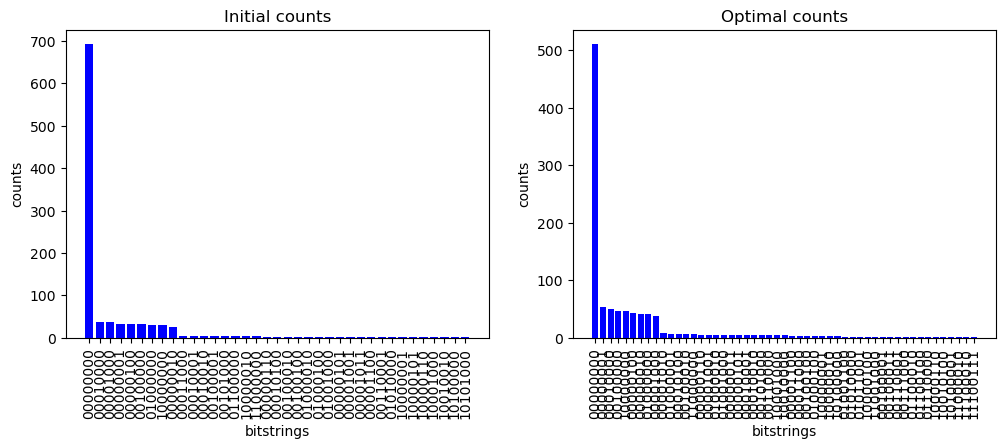

In [243]:
import matplotlib.pyplot as plt

# Known solutions to the QUBO problem.
solution_bitstrings = ["01011", "00111"]

def plot_distribution(C, ax, title):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in solution_bitstrings else "b" for key in C}
    ax.set_xlabel("bitstrings")
    ax.set_ylabel("counts")
    ax.set_xticks([i for i in range(len(C.keys()))], C.keys(), rotation=90)
    ax.bar(C.keys(), C.values(), color=color_dict.values())
    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_distribution(initial_counts, axs[0], "Initial counts")
plot_distribution(optimal_counts, axs[1], "Optimal counts")

In [ ]:
reduced_terms, constraints = dimod.reduce_binary_polynomial(poly)
for (u, v), p in constraints:
        # add a constraint enforcing the relationship between p == u*v
        if vartype is Vartype.BINARY:
            constraint = and_gate(u, v, p)
            bqm.info['reduction'][(u, v)] = {'product': p}
        elif vartype is Vartype.SPIN:
            aux = _new_aux(variables, u, v)  # need an aux in SPIN-space
            constraint = _spin_product([u, v, p, aux])
            bqm.info['reduction'][(u, v)] = {'product': p, 'auxiliary': aux}
        else:
            raise RuntimeError("unknown vartype: {!r}".format(vartype))

        # scale constraint and update the polynomial with it
        constraint.scale(strength)
        for v, bias in constraint.linear.items():
            bqm.add_variable(v, bias)
        for uv, bias in constraint.quadratic.items():
            bqm.add_interaction(*uv, bias)
        bqm.offset += constraint.offset

    _init_objective(bqm, reduced_terms)

In [64]:
for (u, v), p in constraints:
    print((u, v))
    print(p)
    break

(3, 4)
3*4


In [ ]:
import dimod.generators

dimod.generators.and_gate(u,v,p)

BinaryQuadraticModel({3: 0.0, 4: 0.0, '3*4': 3.0}, {(4, 3): 1.0, ('3*4', 3): -2.0, ('3*4', 4): -2.0}, 0.0, 'BINARY')

In [ ]:
dimod.higherorder.utils.make_quadratic(convert_dict(result.terms), 1e3, dimod.SPIN)

BinaryQuadraticModel({'s12': -1997.0201188128535, 's14': -2008.6500911976143, 's12*s14': -2000.0, 'auxs12,s14': -1000.0, 's9': -2008.6500911976143, 's11': -1997.0011369676215, 's9*s11': -2000.0, 'auxs9,s11': -1000.0, 's6': -2008.6500911976143, 's4': -1997.0201188128535, 's6*s4': -2000.0, 'auxs6,s4': -1000.0, 's1': -2004.8056062208968, 's0': -1998.3767726504338, 's1*s0': -2000.0, 'auxs1,s0': -1000.0, 's15': -1997.0011369676215, 's13': -2008.6500911976143, 's15*s13': -2000.0, 'auxs15,s13': -1000.0, 's7': -1997.0011369676215, 's5': -2008.6500911976143, 's7*s5': -2000.0, 'auxs7,s5': -1000.0, 's10': -2008.6500911976143, 's8': -1997.0201188128535, 's10*s8': -2000.0, 'auxs10,s8': -1000.0, 's3': -1998.3588354687627, 's2': -2004.8056062208968, 's3*s2': -2000.0, 'auxs3,s2': -1000.0, 's12*s13': -500.0, 'auxs12,s13': -1000.0, 's3*s2*s0': -500.0, 'auxs3*s2,s0': -1000.0, 's9*s10': -500.0, 'auxs9,s10': -1000.0, 's9*s10*s8': -500.0, 'auxs9,s10*s8': -1000.0, 's12*s14*s15*s13': -500.0, 'auxs12*s14,s15*s

In [245]:
#set sampler to perform the annealing
from neal import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler() #uses simulated annealing, see D-Wave's ocean sdk for more options

In [247]:
### XBK method ###

#set r value
r = 1

#construct qubit Hamiltonians and C terms for XBK method
qubit_Hs, qubit_Cs = [],[]
for p in range(int(math.ceil(r/2+1))):
    qubit_Hs += [XBK_transform(qubit_H, r, p)]
    qubit_Cs += [construct_C(m, r, p)]

#run XBK method
XBK_energy, ground_state = XBK(qubit_Hs, qubit_Cs, r, sampler, starting_lam=0, num_samples=1000, strength=1e3, verbose=False)

print(XBK_energy)
print(ground_state) #ground state in rm-qubit space

BinaryQuadraticModel({'s1': -507.6889699534349, 's0': -497.35928227224866, 's1*s0': -500.0, 'auxs1,s0': -1000.0, 's3': -497.3405615929069, 's2': -507.6889699534349, 's3*s2': -500.0, 'auxs3,s2': -1000.0}, {('s0', 's1'): 497.36259939394057, ('s1*s0', 's1'): 500.0, ('s1*s0', 's0'): 500.0, ('auxs1,s0', 's1'): 1000.0, ('auxs1,s0', 's0'): 1000.0, ('auxs1,s0', 's1*s0'): 1000.0, ('s3', 's1'): -2.6374006060594435, ('s3', 's0'): 2.659438407093101, ('s3', 's1*s0'): -7.688969953434883, ('s2', 's1'): 7.406640049526931, ('s2', 's0'): -2.6374006060594435, ('s2', 's1*s0'): 7.406640049526931, ('s2', 's3'): 492.3110300465651, ('s3*s2', 's1'): 2.6201111641237462, ('s3*s2', 's0'): -2.6374006060594435, ('s3*s2', 's1*s0'): 2.6201111641237462, ('s3*s2', 's3'): 500.0, ('s3*s2', 's2'): 500.0, ('auxs3,s2', 's3'): 1000.0, ('auxs3,s2', 's2'): 1000.0, ('auxs3,s2', 's3*s2'): 1000.0}, 4012.0523159642116, 'SPIN')
BinaryQuadraticModel({'s1': -507.6889699534349, 's0': -497.35928227224866, 's1*s0': -500.0, 'auxs1,s0': -

/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  index = int(solutions[['energy']].idxmin())
/Users/henry/Downloads/Pasqal_Hackathon_Feb25_Team_04-main/XBK_method.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) in

In [10]:
from openfermion import get_sparse_operator